# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

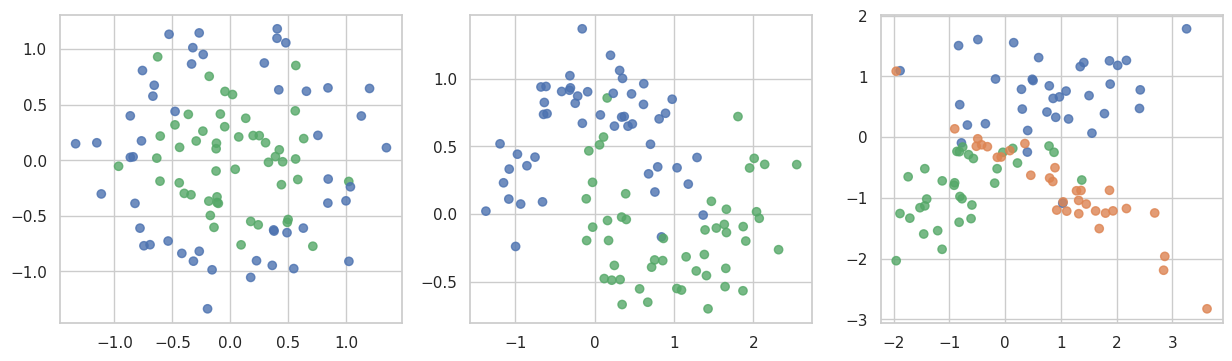

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

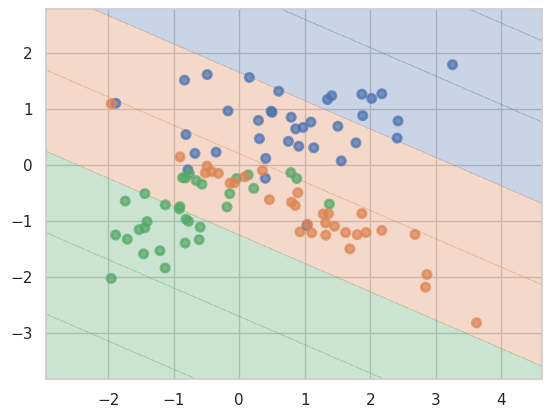

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

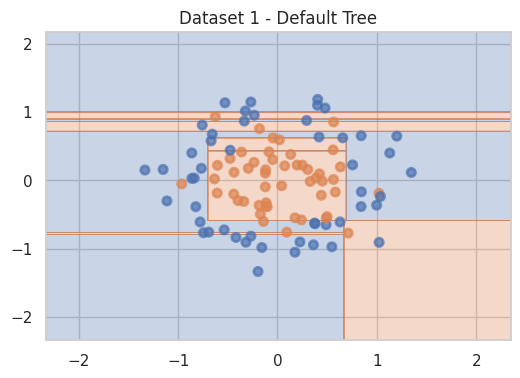

Dataset 1:
  Train Accuracy: 1.0000
  Test Accuracy:  0.7333
  Overfitting:    0.2667
  Сильно переобучилось


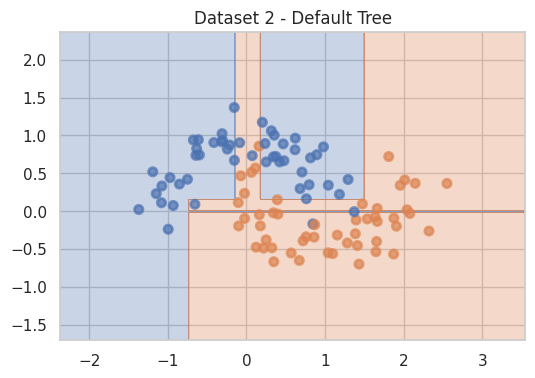

Dataset 2:
  Train Accuracy: 1.0000
  Test Accuracy:  0.8667
  Overfitting:    0.1333
  Сильно переобучилось


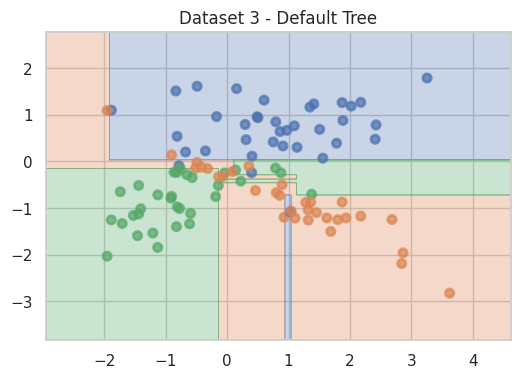

Dataset 3:
  Train Accuracy: 1.0000
  Test Accuracy:  0.8333
  Overfitting:    0.1667
  Сильно переобучилось


In [7]:
from sklearn.metrics import accuracy_score

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(6, 4))
    plot_surface(clf, X, y) 
    plt.title(f'Dataset {i+1} - Default Tree')
    plt.show()

    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)

    print(f"Dataset {i+1}:")
    print(f"  Train Accuracy: {acc_train:.4f}")
    print(f"  Test Accuracy:  {acc_test:.4f}")
    print(f"  Overfitting:    {acc_train - acc_test:.4f}")
    if (acc_train - acc_test) > 0.1: 
        print("  Сильно переобучилось")
    else:
        print("  Переобучение не сильное")

__Ответ:__ Деревья по умолчанию склонны к сильному переобучению на всех рассмотренных датасетах, так как разница между обучающей и тестовой точностью превышает 0.1.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


 Testing params: {'max_depth': 1, 'min_samples_leaf': 1}


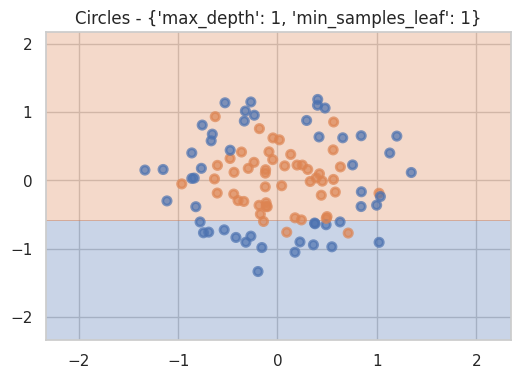

  Params: {'max_depth': 1, 'min_samples_leaf': 1}
  Train Acc: 0.7286
  Test Acc:  0.4667
  Diff (Train-Test): 0.2619

 Testing params: {'max_depth': 3, 'min_samples_leaf': 1}


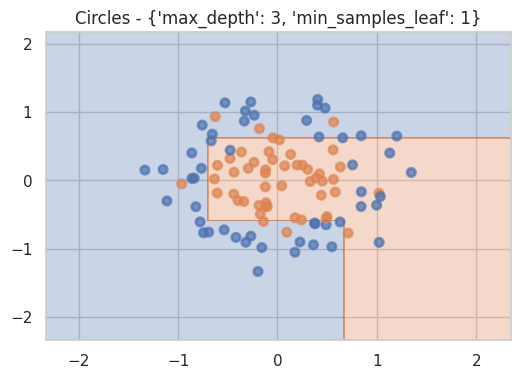

  Params: {'max_depth': 3, 'min_samples_leaf': 1}
  Train Acc: 0.8857
  Test Acc:  0.7333
  Diff (Train-Test): 0.1524

 Testing params: {'max_depth': 5, 'min_samples_leaf': 1}


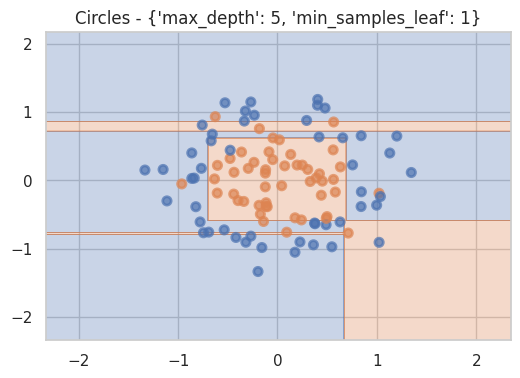

  Params: {'max_depth': 5, 'min_samples_leaf': 1}
  Train Acc: 0.9714
  Test Acc:  0.7667
  Diff (Train-Test): 0.2048

 Testing params: {'max_depth': 10, 'min_samples_leaf': 1}


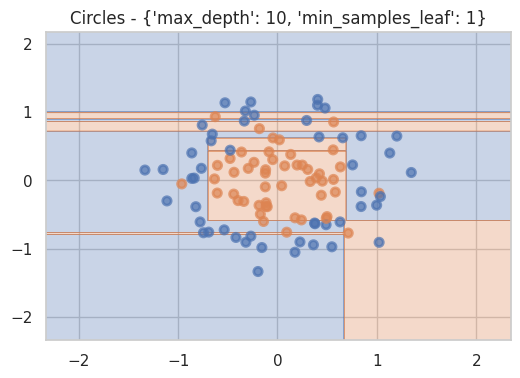

  Params: {'max_depth': 10, 'min_samples_leaf': 1}
  Train Acc: 1.0000
  Test Acc:  0.7333
  Diff (Train-Test): 0.2667

 Testing params: {'max_depth': 3, 'min_samples_leaf': 5}


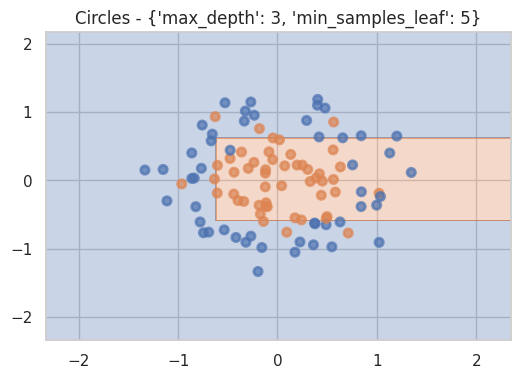

  Params: {'max_depth': 3, 'min_samples_leaf': 5}
  Train Acc: 0.8571
  Test Acc:  0.8000
  Diff (Train-Test): 0.0571

 Testing params: {'max_depth': 5, 'min_samples_leaf': 5}


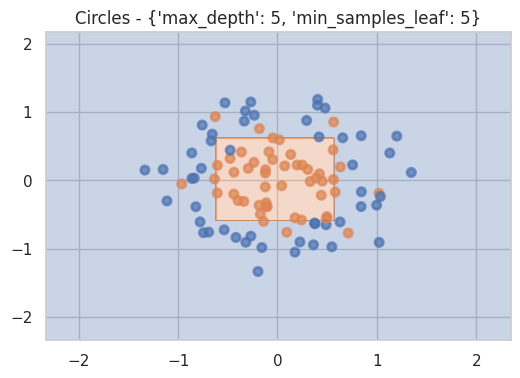

  Params: {'max_depth': 5, 'min_samples_leaf': 5}
  Train Acc: 0.8714
  Test Acc:  0.9000
  Diff (Train-Test): -0.0286

 Testing params: {'max_depth': 10, 'min_samples_leaf': 10}


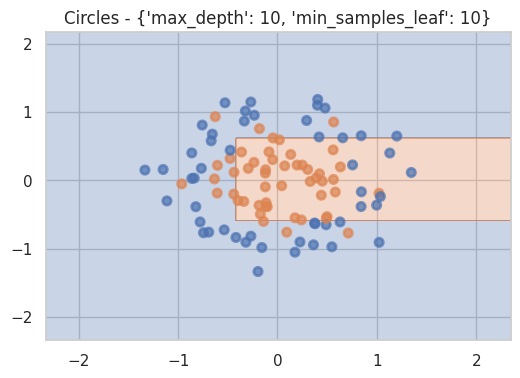

  Params: {'max_depth': 10, 'min_samples_leaf': 10}
  Train Acc: 0.8143
  Test Acc:  0.7667
  Diff (Train-Test): 0.0476


In [8]:
X, y = datasets[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_combinations = [
    {'max_depth': 1, 'min_samples_leaf': 1},
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 1},
    {'max_depth': 10, 'min_samples_leaf': 1},
    {'max_depth': 3, 'min_samples_leaf': 5},
    {'max_depth': 5, 'min_samples_leaf': 5},
    {'max_depth': 10, 'min_samples_leaf': 10},
]

for params in param_combinations:
    print(f"\n Testing params: {params}")
    clf = DecisionTreeClassifier(random_state=42, **params)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(6, 4))
    plot_surface(clf, X, y)
    plt.title(f'Circles - {params}')
    plt.show()

    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)

    print(f"  Params: {params}")
    print(f"  Train Acc: {acc_train:.4f}")
    print(f"  Test Acc:  {acc_test:.4f}")
    print(f"  Diff (Train-Test): {acc_train - acc_test:.4f}")


__Ответ:__
Увеличение max_depth приводит к более сложной разделяющей поверхности, что может улучшить качество на тренировочной выборке, но увеличивает риск переобучения. Увеличение min_samples_leaf сглаживает поверхность, ограничивая способность модели к подгонке под шум, что может улучшить обобщающую способность, но при чрезмерно больших значениях может привести к недообучению (низкое качество как на тренировке, так и на тесте). Влияние этих параметров в целом одинаково для разных датасетов, хотя конкретные оптимальные значения могут отличаться в зависимости от структуры данных и сложности разделяющей поверхности.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

Столбцы в датасете:
['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS']

Первые несколько строк:
    STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0

Признаки: ['STG', 'SCG', 'STR', 'LPR', 'PEG']
Целевая переменная: UNS

Обработка признака 'STG':
  Уникальных значений: 75
  Диапазон значений: от 0.0 до 0.99
  find_best_split вернула порогов: 74
  Успешно добавлена кривая для 'STG'.

Обработка признака 'SCG':
  Уникальных значений: 71
  Диапазон значений: от 0.0 до 0.9
  find_best_split вернула порогов: 70
  Успешно добавлена кривая для 'SCG'.

Обработка признака 'STR':
  Уникальных значений: 83
  Диапазон значений: от 0.0 до 0.95
  find_best_split вернула порогов: 82
  Успешно добавлена кривая для 'STR'.

Обработка признака 'LPR':
  Уникальных значений: 80
  Диапазон значений: от 0.0 до 0.99
  find_best_split вернула порогов: 7

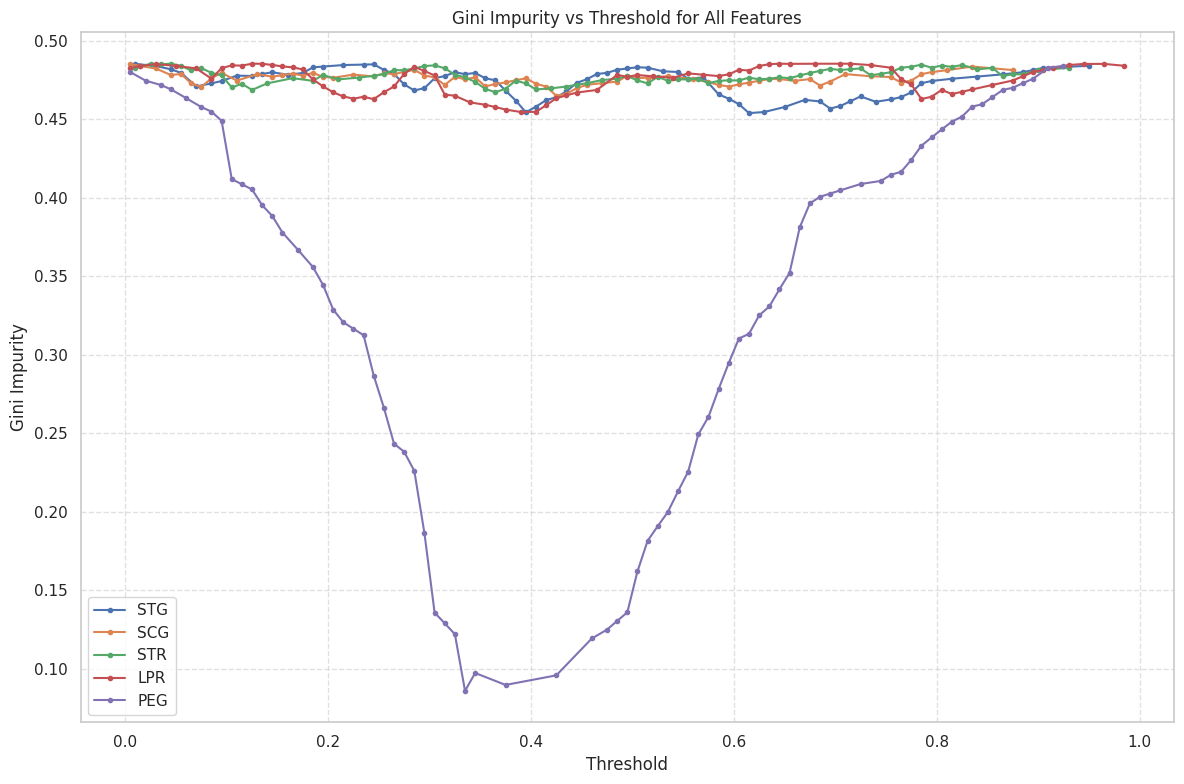


Отображено 5 кривых на общем графике.

Построение Scatter Plots
  Scatter plot для 'STG'. Уникальные значения целевой переменной: [np.int64(0), np.int64(1)]


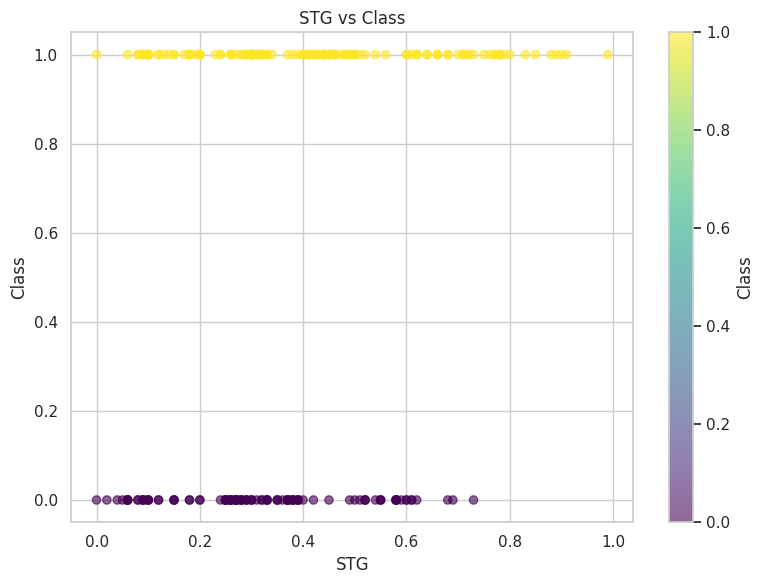

  Scatter plot для 'SCG'. Уникальные значения целевой переменной: [np.int64(0), np.int64(1)]


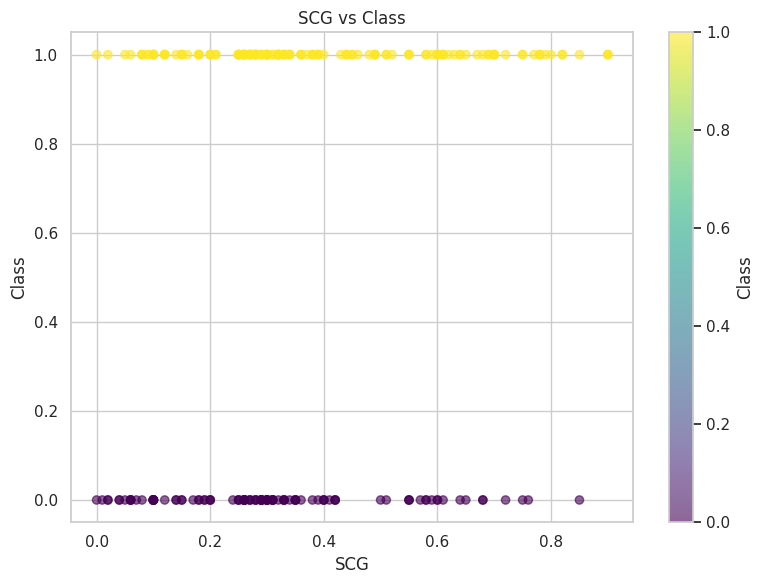

  Scatter plot для 'STR'. Уникальные значения целевой переменной: [np.int64(0), np.int64(1)]


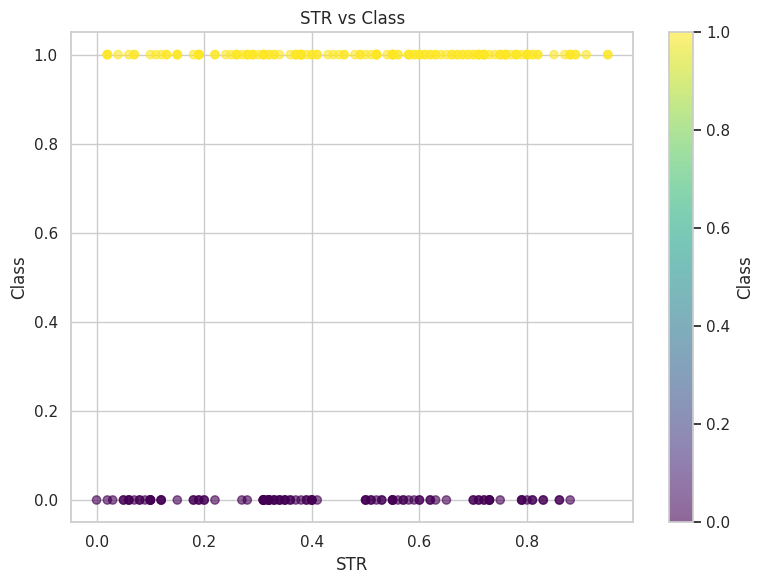

  Scatter plot для 'LPR'. Уникальные значения целевой переменной: [np.int64(0), np.int64(1)]


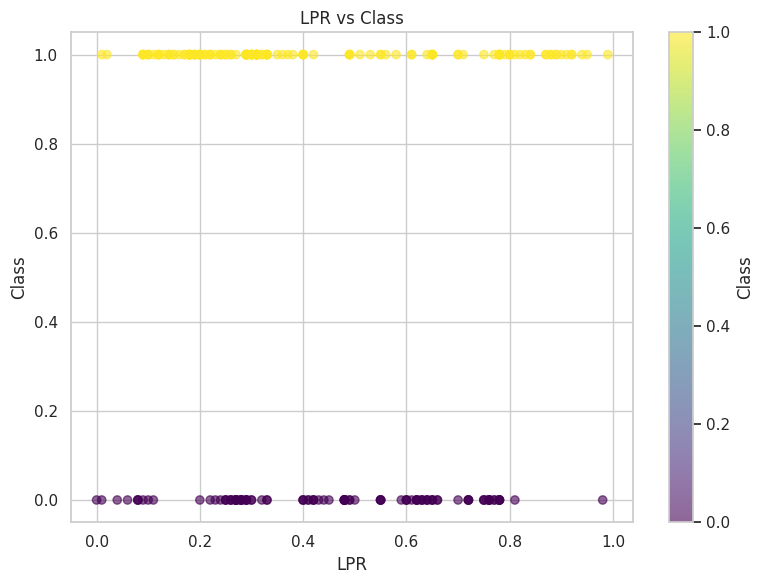

  Scatter plot для 'PEG'. Уникальные значения целевой переменной: [np.int64(0), np.int64(1)]


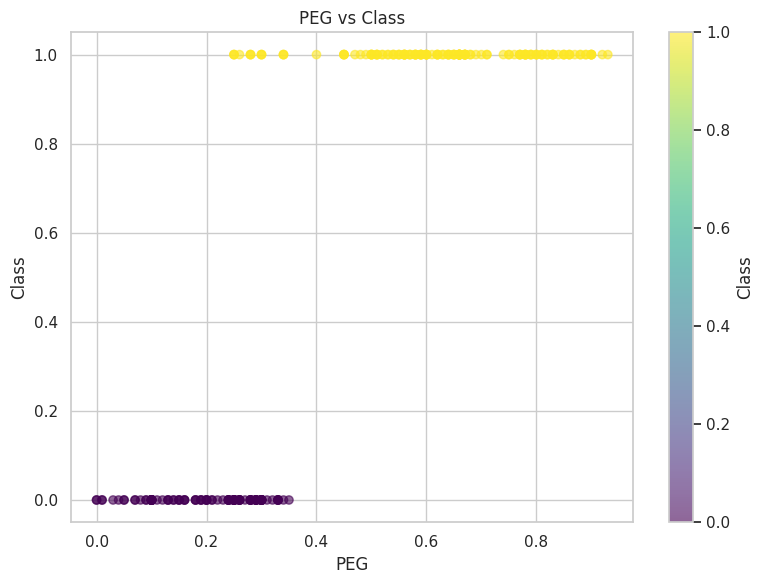

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hw2code import find_best_split 

df_students = pd.read_csv('students.csv')

print("Столбцы в датасете:")
print(df_students.columns.tolist())
print("\nПервые несколько строк:")
print(df_students.head())

feature_cols = df_students.columns[:5] 
target_col = df_students.columns[-1]    

print(f"\nПризнаки: {feature_cols.tolist()}")
print(f"Целевая переменная: {target_col}")

plt.figure(figsize=(12, 8))

plots_drawn = 0

for i, col in enumerate(feature_cols):
    try:
        feature_values = df_students[col].values
        target_values = df_students[target_col].values

        print(f"\nОбработка признака '{col}':")
        print(f"  Уникальных значений: {len(np.unique(feature_values))}")
        print(f"  Диапазон значений: от {np.min(feature_values)} до {np.max(feature_values)}")

        if len(np.unique(feature_values)) > 1:
            thresholds, ginis, _, _ = find_best_split(feature_values, target_values)

            print(f"  find_best_split вернула порогов: {len(thresholds)}")

            if len(thresholds) > 0:
                plt.plot(thresholds, ginis, label=f'{col}', marker='o', linestyle='-', markersize=3)
                plots_drawn += 1
                print(f"  Успешно добавлена кривая для '{col}'.")
            else:
                print(f"  Для признака {col} не найдено возможных порогов для разбиения.")
        else:
            print(f"  Признак {col} константный, пропускаем.")

    except Exception as e:
        print(f"Ошибка при обработке признака {col}: {e}")

if plots_drawn > 0:
    plt.title('Gini Impurity vs Threshold for All Features')
    plt.xlabel('Threshold')
    plt.ylabel('Gini Impurity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print(f"\nОтображено {plots_drawn} кривых на общем графике.")
else:
    print("\nНе удалось построить ни одной кривой на общем графике. ")

print("\nПостроение Scatter Plots")
for i, col in enumerate(feature_cols):
    plt.figure(figsize=(8, 6))
    unique_targets = sorted(df_students[target_col].unique())
    print(f"  Scatter plot для '{col}'. Уникальные значения целевой переменной: {unique_targets}")

    scatter = plt.scatter(df_students[col], df_students[target_col],
                          c=df_students[target_col], cmap='viridis', alpha=0.6)
    plt.title(f'{col} vs Class')
    plt.xlabel(col)
    plt.ylabel('Class')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Class')
    plt.tight_layout()
    plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** 
1. По признаку PEG, так как его кривая Джини имеет самый низкий минимум.
2. Да, признак PEG с самым низким минимумом Джини должен лучше всего визуально разделять классы на scatter-графике.
3. Кривая имеет выраженный, глубокий минимум, значительно ниже значений по краям.
4. Кривая относительно плоская и находится на высоком уровне.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo

import importlib
import hw2code
importlib.reload(hw2code)
from hw2code import DecisionTree

mushroom = fetch_ucirepo(id=73)
X_raw = mushroom.data.features
y_raw = mushroom.data.targets.iloc[:, 0]

print(f"Размер данных: {X_raw.shape}")
print(f"Распределение классов: {y_raw.value_counts()}")

X_processed = X_raw.copy()
label_encoders = {}
for col in X_processed.columns:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le

y_processed = LabelEncoder().fit_transform(y_raw)  

print(f"После кодирования - классы: {np.unique(y_processed)}, распределение: {np.bincount(y_processed)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_processed.values, y_processed, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_processed
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

test_cases = [
    {"max_depth": 3, "min_samples_split": 2, "min_samples_leaf": 1},
    {"max_depth": 5, "min_samples_split": 2, "min_samples_leaf": 1},
    {"max_depth": 10, "min_samples_split": 2, "min_samples_leaf": 1},
    {"max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
]

feature_types = ["categorical"] * X_processed.shape[1]

success_found = False

for i, params in enumerate(test_cases):
    print(f"\nТест {i+1}: {params}")
    
    tree = DecisionTree(feature_types=feature_types, **params)
    tree.fit(X_train, y_train)
    
    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    
    if test_acc > 0.95:
        success_found = True
        break

if not success_found:
    print("\nНи один набор параметров не дал accuracy > 0.95")
    print("Условию задания не соответствует")

Размер данных: (8124, 22)
Распределение классов: poisonous
e    4208
p    3916
Name: count, dtype: int64
После кодирования - классы: [0 1], распределение: [4208 3916]
Train: (4062, 22), Test: (4062, 22)

Тест 1: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}
Train Accuracy: 0.9968
Test Accuracy:  0.9973


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

max_depth=1, Accuracy=0.6917
max_depth=2, Accuracy=0.6625
max_depth=3, Accuracy=0.7208
max_depth=4, Accuracy=0.8000
max_depth=5, Accuracy=0.8792
max_depth=6, Accuracy=0.9042
max_depth=7, Accuracy=0.9292
max_depth=8, Accuracy=0.9333
max_depth=9, Accuracy=0.9292
max_depth=10, Accuracy=0.9292


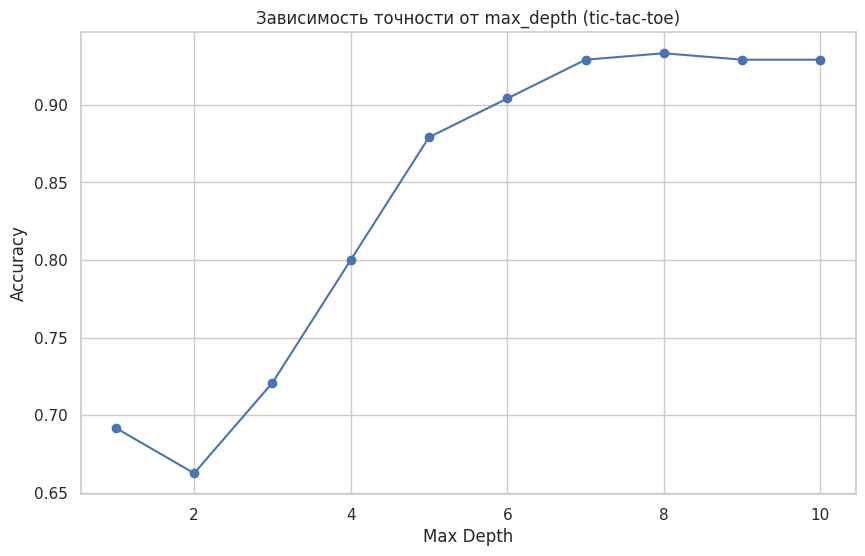

min_samples_split=2, Accuracy=0.9292
min_samples_split=3, Accuracy=0.9208
min_samples_split=4, Accuracy=0.9208
min_samples_split=5, Accuracy=0.9208
min_samples_split=6, Accuracy=0.9083
min_samples_split=7, Accuracy=0.9083
min_samples_split=8, Accuracy=0.8833
min_samples_split=9, Accuracy=0.8792
min_samples_split=10, Accuracy=0.8833
min_samples_split=11, Accuracy=0.8833
min_samples_split=12, Accuracy=0.8833
min_samples_split=13, Accuracy=0.8875
min_samples_split=14, Accuracy=0.8875
min_samples_split=15, Accuracy=0.8833
min_samples_split=16, Accuracy=0.8792
min_samples_split=17, Accuracy=0.8792
min_samples_split=18, Accuracy=0.8792
min_samples_split=19, Accuracy=0.8792
min_samples_split=20, Accuracy=0.8792


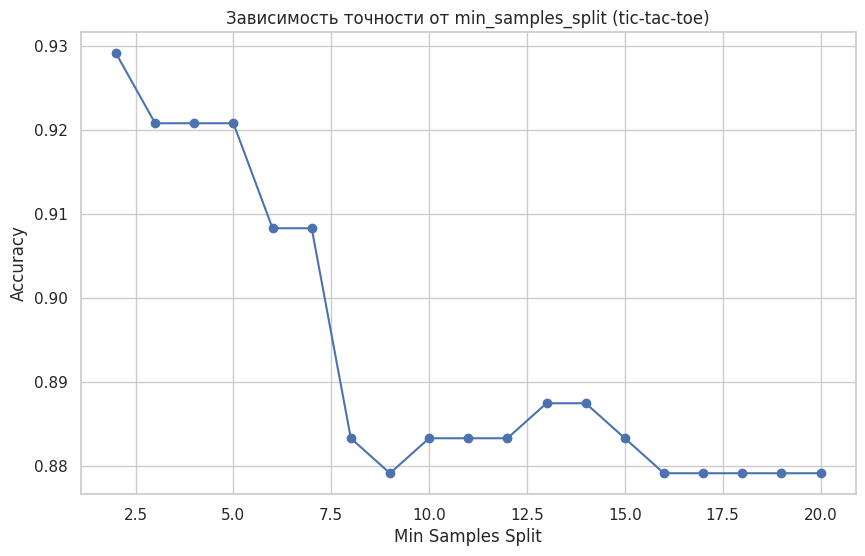

min_samples_leaf=1, Accuracy=0.9292
min_samples_leaf=2, Accuracy=0.9083
min_samples_leaf=3, Accuracy=0.9167
min_samples_leaf=4, Accuracy=0.9042
min_samples_leaf=5, Accuracy=0.8958
min_samples_leaf=6, Accuracy=0.8917
min_samples_leaf=7, Accuracy=0.8917
min_samples_leaf=8, Accuracy=0.9083
min_samples_leaf=9, Accuracy=0.9083
min_samples_leaf=10, Accuracy=0.9167


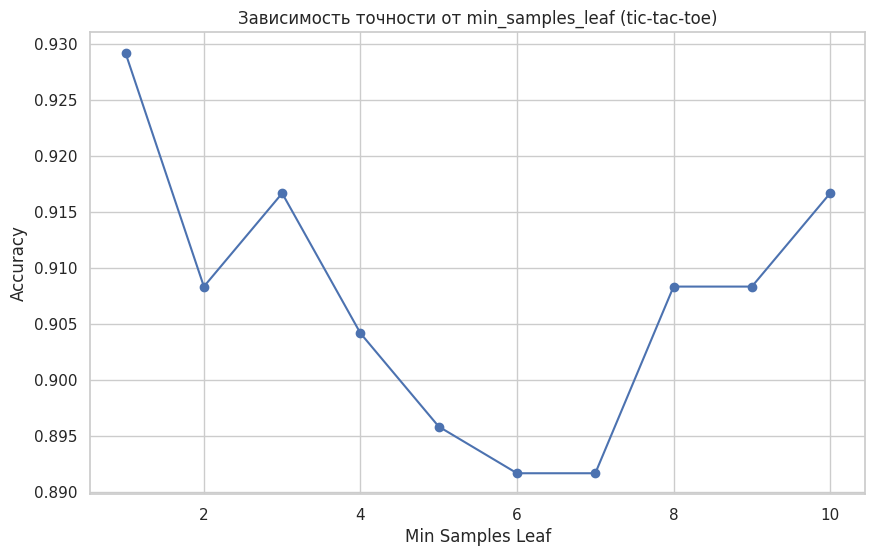

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from hw2code import DecisionTree

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
col_names = [f'pos_{i}' for i in range(9)] + ['result']
df = pd.read_csv(url, names=col_names)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

le = LabelEncoder()
X_encoded = X.apply(lambda col: le.fit_transform(col))
y_encoded = (y == 'positive').astype(int)

X_full = X_encoded.values
y_full = y_encoded.values

feature_types = ["categorical"] * X_full.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.25, random_state=42, stratify=y_full
)

def evaluate_model_param(model_class, X_tr, y_tr, X_te, y_te, **params):
    """Вспомогательная функция для оценки модели с заданными параметрами."""
    tree = model_class(feature_types, **params)
    tree.fit(X_tr, y_tr)
    y_pred = tree.predict(X_te)
    return accuracy_score(y_te, y_pred)

# 1. График для max_depth
max_depths = range(1, 11)
accuracies_depth = []

for depth in max_depths:
    acc = evaluate_model_param(DecisionTree, X_train, y_train, X_test, y_test, max_depth=depth)
    accuracies_depth.append(acc)
    print(f"max_depth={depth}, Accuracy={acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies_depth, marker='o')
plt.title('Зависимость точности от max_depth (tic-tac-toe)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 2. График для min_samples_split
min_samples_splits = range(2, 21)
accuracies_mss = []

for mss in min_samples_splits:
    acc = evaluate_model_param(DecisionTree, X_train, y_train, X_test, y_test, min_samples_split=mss)
    accuracies_mss.append(acc)
    print(f"min_samples_split={mss}, Accuracy={acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(min_samples_splits, accuracies_mss, marker='o')
plt.title('Зависимость точности от min_samples_split (tic-tac-toe)')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 3. График для min_samples_leaf
min_samples_leafs = range(1, 11)
accuracies_msl = []

for msl in min_samples_leafs:
    acc = evaluate_model_param(DecisionTree, X_train, y_train, X_test, y_test, min_samples_leaf=msl)
    accuracies_msl.append(acc)
    print(f"min_samples_leaf={msl}, Accuracy={acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leafs, accuracies_msl, marker='o')
plt.title('Зависимость точности от min_samples_leaf (tic-tac-toe)')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from hw2code import DecisionTree 

def load_mushrooms():
    print("Загрузка mushrooms...")
    from ucimlrepo import fetch_ucirepo
    mushroom = fetch_ucirepo(id=73)
    X_raw = mushroom.data.features
    y_raw = mushroom.data.targets.iloc[:, 0] 

    X_encoded = X_raw.copy()
    feature_encoders = {}
    for col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        feature_encoders[col] = le

    y_encoded = LabelEncoder().fit_transform(y_raw)
    return X_encoded.values, y_encoded

def load_tic_tac_toe():
    print("Загрузка tic-tac-toe...")
    col_names_ttt = [f'pos_{i}' for i in range(9)] + ['result']
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
    raw_data_frame = pd.read_csv(url, names=col_names_ttt)

    X_raw = raw_data_frame.iloc[:, :-1]
    y_raw = raw_data_frame.iloc[:, -1]

    X_encoded = X_raw.copy()
    feature_encoders = {}
    for col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        feature_encoders[col] = le

    y_encoded = LabelEncoder().fit_transform(y_raw)
    return X_encoded.values, y_encoded

def load_cars():
    print("Загрузка cars...")
    col_names_cars = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
    raw_data_frame = pd.read_csv(url, names=col_names_cars)

    X_raw = raw_data_frame.iloc[:, :-1]
    y_raw = raw_data_frame.iloc[:, -1]

    y_mapped = y_raw.map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    if y_mapped.isna().any():
        raise ValueError("Найдены неожиданные значения в целевой переменной cars.")
    y_encoded = y_mapped.astype(int)

    X_encoded = X_raw.copy()
    feature_encoders = {}
    for col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        feature_encoders[col] = le

    return X_encoded.values, y_encoded.values

def load_nursery():
    print("Загрузка nursery...")
    col_names_nursery = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
    raw_data_frame = pd.read_csv(url, names=col_names_nursery)

    X_raw = raw_data_frame.iloc[:, :-1]
    y_raw = raw_data_frame.iloc[:, -1]

    # Преобразуем целевую переменную: not_recom, recommend -> 0; very_recom, priority, spec_prior -> 1
    y_mapped = y_raw.map({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})
    # Проверяем, что все значения были преобразованы
    if y_mapped.isna().any():
        raise ValueError("Найдены неожиданные значения в целевой переменной nursery.")
    y_encoded = y_mapped.astype(int)

    # Кодируем признаки
    X_encoded = X_raw.copy()
    feature_encoders = {}
    for col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        feature_encoders[col] = le

    return X_encoded.values, y_encoded.values


# Загрузка датасетов
datasets = {}
try:
    X_m, y_m = load_mushrooms()
    datasets['mushrooms'] = (X_m, y_m)
except Exception as e:
    print(f"Ошибка при загрузке mushrooms: {e}")

try:
    X_ttt, y_ttt = load_tic_tac_toe()
    datasets['tic-tac-toe'] = (X_ttt, y_ttt)
except Exception as e:
    print(f"Ошибка при загрузке tic-tac-toe: {e}")

try:
    X_c, y_c = load_cars()
    datasets['cars'] = (X_c, y_c)
except Exception as e:
    print(f"Ошибка при загрузке cars: {e}")

try:
    X_n, y_n = load_nursery()
    datasets['nursery'] = (X_n, y_n)
except Exception as e:
    print(f"Ошибка при загрузке nursery: {e}")

if not datasets:
    raise ValueError("Ни один из датасетов не был успешно загружен.")

def evaluate_model_manual(model, X, y, cv=10, random_state=42):
    scorer = make_scorer(accuracy_score)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        import copy
        model_clone = copy.deepcopy(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)
        score = scorer(model_clone, X_test, y_test)
        scores.append(score)
    return np.mean(scores)


results_df = pd.DataFrame(index=datasets.keys(), columns=[
    'DecisionTree (real)',
    'DecisionTree (categorical)',
    'DecisionTree (real + one-hot)',
    'DecisionTreeClassifier (sklearn)'
])

for dataset_name, (X, y) in datasets.items():
    print(f"\nОбработка датасета: {dataset_name}")
    print(f"Форма X: {X.shape}, Уникальные значения y: {np.unique(y)}")

    print("  Оценка DecisionTree (real)...")
    try:
        tree_real = DecisionTree(feature_types=["real"] * X.shape[1])
        score_real = evaluate_model_manual(tree_real, X, y)
        results_df.loc[dataset_name, 'DecisionTree (real)'] = score_real
    except Exception as e:
        print(f"    Ошибка: {e}")
        results_df.loc[dataset_name, 'DecisionTree (real)'] = np.nan

    print("  Оценка DecisionTree (categorical)...")
    try:
        tree_cat = DecisionTree(feature_types=["categorical"] * X.shape[1])
        score_cat = evaluate_model_manual(tree_cat, X, y)
        results_df.loc[dataset_name, 'DecisionTree (categorical)'] = score_cat
    except Exception as e:
        print(f"    Ошибка: {e}")
        results_df.loc[dataset_name, 'DecisionTree (categorical)'] = np.nan

    print("  Оценка DecisionTree (real + one-hot)...")
    try:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
        X_ohe = ohe.fit_transform(X)
        tree_real_ohe = DecisionTree(feature_types=["real"] * X_ohe.shape[1])
        score_real_ohe = evaluate_model_manual(tree_real_ohe, X_ohe, y)
        results_df.loc[dataset_name, 'DecisionTree (real + one-hot)'] = score_real_ohe
    except Exception as e:
        print(f"    Ошибка: {e}")
        results_df.loc[dataset_name, 'DecisionTree (real + one-hot)'] = np.nan

    print("  Оценка DecisionTreeClassifier (sklearn)...")
    try:
        tree_sklearn = DecisionTreeClassifier(random_state=42)
        scorer = make_scorer(accuracy_score)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        scores_sklearn = cross_val_score(tree_sklearn, X, y, cv=skf, scoring=scorer, n_jobs=-1) 
        score_sklearn = scores_sklearn.mean()
        results_df.loc[dataset_name, 'DecisionTreeClassifier (sklearn)'] = score_sklearn
    except Exception as e:
        print(f"    Ошибка: {e}")
        results_df.loc[dataset_name, 'DecisionTreeClassifier (sklearn)'] = np.nan

    print(f"  Результаты для {dataset_name} сохранены.")

print("\nИтоговая таблица результатов")
print(results_df.round(4))


Загрузка mushrooms...
Загрузка tic-tac-toe...
Загрузка cars...
Загрузка nursery...

Обработка датасета: mushrooms
Форма X: (8124, 22), Уникальные значения y: [0 1]
  Оценка DecisionTree (real)...
  Оценка DecisionTree (categorical)...
  Оценка DecisionTree (real + one-hot)...
  Оценка DecisionTreeClassifier (sklearn)...
  Результаты для mushrooms сохранены.

Обработка датасета: tic-tac-toe
Форма X: (958, 9), Уникальные значения y: [0 1]
  Оценка DecisionTree (real)...
  Оценка DecisionTree (categorical)...
  Оценка DecisionTree (real + one-hot)...
  Оценка DecisionTreeClassifier (sklearn)...
  Результаты для tic-tac-toe сохранены.

Обработка датасета: cars
Форма X: (1728, 6), Уникальные значения y: [0 1]
  Оценка DecisionTree (real)...
  Оценка DecisionTree (categorical)...
  Оценка DecisionTree (real + one-hot)...
  Оценка DecisionTreeClassifier (sklearn)...
  Результаты для cars сохранены.

Обработка датасета: nursery
Форма X: (12960, 8), Уникальные значения y: [0 1]
  Оценка Decisio

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** 
Для разных наборов данных алгоритмы действительно ранжируются по-разному:
- Mushrooms: Все методы показывают высокую точность, так как признаки имеют сильную предсказательную силу
- Tic-Tac-Toe: Категориальные деревья работают лучше, поскольку позиции на доске - это дискретные состояния
- Cars: One-hot encoding может ухудшать результаты из-за увеличения размерности
- Nursery: Вещественные признаки часто проигрывают из-за потери информации о порядковых отношениях

Присутствует значительная компонента случайности из-за:
- Разбиения на train/test
- Начальной инициализации в некоторых алгоритмах
- Порядка обработки признаков

Пути улучшения:
- Использование стратифицированной кросс-валидации
- Усреднение по нескольким запускам с разными random_state
- Тюнинг гиперпараметров для каждого датасета
- Использование ансамблевых методов

Вставьте что угодно, описывающее ваши впечатления от этого задания: